<a href="https://www.kaggle.com/code/fiftythirtyfour/airline-delays?scriptVersionId=162795068" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
import warnings
warnings.filterwarnings("ignore")

# Load
ref = pd.read_csv('/kaggle/input/flight-delays/airports.csv')
airlines = pd.read_csv('/kaggle/input/flight-delays/airlines.csv')
df = pd.read_csv('/kaggle/input/flight-delays/flights.csv'
    , dtype={'ORIGIN_AIRPORT': 'object'
             , 'DESTINATION_AIRPORT': 'object'
             , 'SCHEDULED_DEPARTURE': 'object'
             , 'SCHEDULED_ARRIVAL': 'object'
             , 'DEPARTURE_TIME': 'object'
             , 'ARRIVAL_TIME': 'object'
             , 'SCHEDULED_TIME': 'object'
             , 'ELAPSED_TIME': 'object'
             , 'AIR_TIME': 'object'
             , 'WHEELS_OFF': 'object'
             , 'WHEELS_ON': 'object'
             , 'TAXI_IN': 'object'
             , 'TAXI_OUT': 'object'})

# Clean
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['otp_dep15'] = np.where(df['departure_delay'] <= 15, 1, 0)

In [2]:
## Cleaning Time
def convert_time(col):
    return pd.to_datetime(col, format='%H%M', errors='coerce').dt.time

tim = ['scheduled_departure', 'departure_time', 'taxi_out',
       'wheels_off', 'scheduled_time', 'elapsed_time', 'air_time',
       'wheels_on', 'taxi_in', 'scheduled_arrival', 'arrival_time']

for tt in tim:
    df[tt] = convert_time(df[tt])

# Organization
tim.append('date')
num = [x for x in df.columns if df.dtypes[x] in ('int', 'float')]
cat = [x for x in df.columns if df.dtypes[x] == 'object' and x not in tim]
target = 'otp_dep15'
num.remove(target)

# Summary Notes
## Version 03. On Time Performance
On Time Performance is important for an airline. By making sure flights are on time, airlines can ensure that they are making money.

## Version 02. Understanding the Target
It is important to understand the metric that we are trying to predict. It guides you through the forest of features. You need to obsess over the target as much as  possible and try to tame it by doing a lot of graphs.

## Version 01
My plan is to start looking at 1 airline to understand the data and find any anomalies. I choose to start with UA airline because it is in the middle of volume and seems to be consistent throughout the year.

There origin airport around October are not iata codes. They are random numbers which looks like placeholder for missing data. It is a pain. I think I should just focus on the first 3 months of the year as training data and use the 4th month as test data.

## Version 00
Merger of American Airlines and US Airways Merger happend around June 2015.


# Explore

## Flights by Airlines
Listed all the flights just to check the integrity of the data and saw some that US airline had only half a year worth of data.

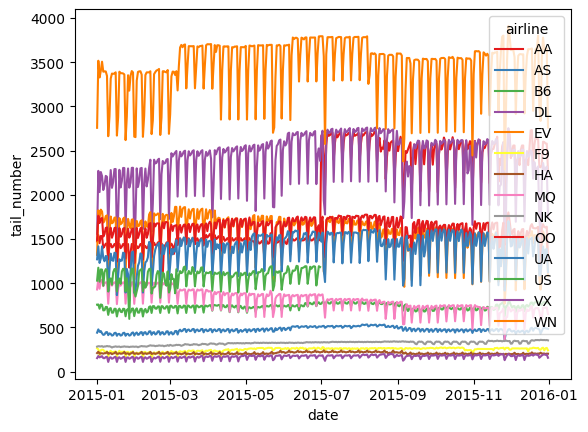

In [3]:
g = df.groupby(['date', 'airline'])['tail_number'].count().reset_index()
g = g
sns.lineplot(data=g, x='date', y='tail_number', hue='airline', palette='Set1');

## American Airlines and US Airways Merger
It turns out that in 2015, US Airways was acquired by American Airlines.

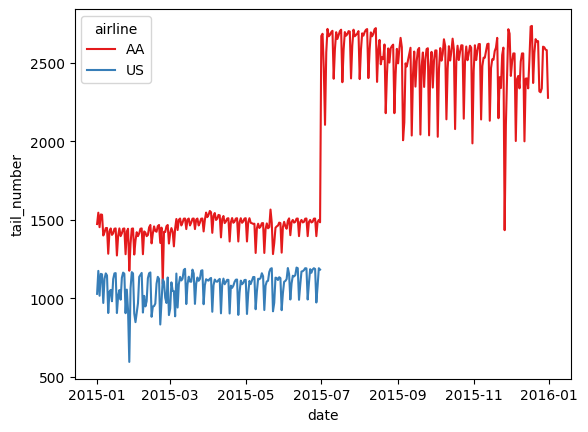

In [4]:
g = df.groupby(['date', 'airline'])['tail_number'].count().reset_index()
g = g.query('airline==["US", "AA"]')
sns.lineplot(data=g, x='date', y='tail_number', hue='airline', palette='Set1');

## On Time Performance

On Time Performance is very important for an airline operation. An airline has X amount of flights scheduled in a given period. Each flight is money for the airline. If a flight does not depart on schedule, it will affect the next flight. If enough flights are late, then it increase the chances of cancelling a flight. This does not only mean a loss of potential revenue but also means cost to the airline because it has already paid for most of the stuff to operate that cancelled flight. Therefore, it is important to know how often does a flight depart late, what causes it and how can we prevent it from happening.

Airline industry defines a flight to be on time if it departed within 15 minutes of schedule. Airlines can handle a few delayed flights. It does not matter how long a flight was delayed. A flight that is delayed for 3+hours is manageable. 50 flights that are delayed for 16 minutes is trouble. Airlines can always use a spare aircraft or another aircraft that arrived early to take on the next flight. But they can only do that a finite amount of time because they would want all of their aircrafts to be flying. Therefore, it does not matter how long a flight is delayed, what matters is the frequency.

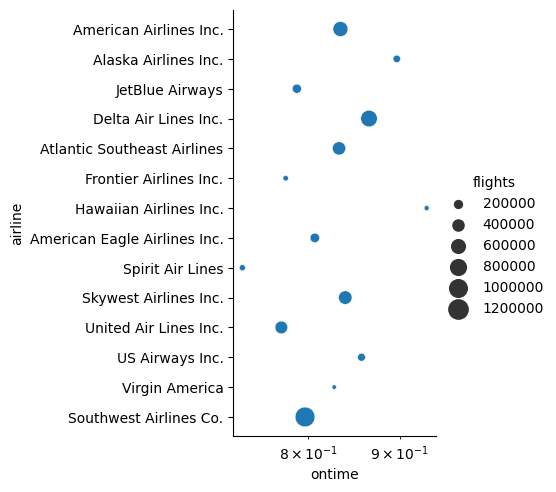

In [5]:
g = df.loc[(df['diverted']==0) & (df['cancelled']==0)]
# g[target].mean()
g = g.groupby('airline')[target].agg(['mean', 'count'])
g = g.reset_index()
g['airline'] = g['airline'].map(airlines.set_index('IATA_CODE')['AIRLINE'])
g.columns = ['airline', 'ontime', 'flights']
sns.relplot(data=g, x='ontime', y='airline', size='flights', sizes=(10, 200))
plt.xscale('log')  # Apply logarithmic scale to the size axis
plt.show()

Here we can see that some Hawaiian Airlines and Alaska Airlines are almost always on time but the volume of flights are low. Delta Airlines are not the best but relative to their size, they have an impressive on-time performance. Spirit Airlines is almost always late and relative to their size, they are really performing bad.